# Graduate Admission 

Nous allons étudier les facteurs qui déterminent l'admission d'un élève à un master en université américaine. 

Parmi ces facteurs, on compte : 

1. GRE Scores ( out of 340 ) 
2. TOEFL Scores ( out of 120 ) 
3. University Rating ( out of 5 ) 
4. Statement of Purpose and Letter of Recommendation Strength ( out of 5 ) 
5. Undergraduate GPA ( out of 10 ) 
6. Research Experience ( either 0 or 1 ) 
7. Chance of Admit ( ranging from 0 to 1 )

0. Importez les librairies usuelles

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

1. Importez le dataset et affichez le sous forme de DataFrame 

In [ ]:
dataset = pd.read_csv("Admission_Predict_Ver1.1.csv")

In [ ]:
dataset.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [ ]:
dataset = dataset.drop("Serial No.", axis=1)

In [ ]:
dataset.columns

Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA',
       'Research', 'Chance of Admit '],
      dtype='object')

2. Notre variable est exprimée comme une probabilité. On voudrait que ce soit plutôt une classe. Remplacez donc toutes les probabilités supérieures à 75% par 1 et les autres par 0 

In [ ]:
dataset.iloc[:, -1] = dataset.iloc[:, -1].apply(lambda x: 1 if x>=0.75 else 0)
dataset.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,1
1,324,107,4,4.0,4.5,8.87,1,1
2,316,104,3,3.0,3.5,8.00,1,0
3,322,110,3,3.5,2.5,8.67,1,1
4,314,103,2,2.0,3.0,8.21,0,0


3. Regardez la répartition de GRE Score par rapport à l'admission 

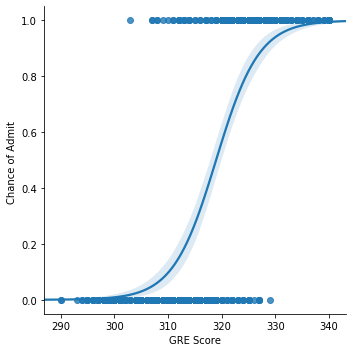

In [ ]:
sns.lmplot(x=dataset.columns[0], 
           y=dataset.columns[-1], 
           data=dataset,
           logistic=True)

4. Faites de même avec le Toefl Score  / CGPA

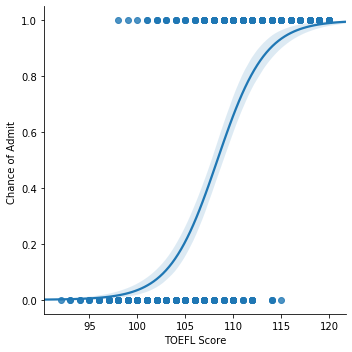

In [ ]:
sns.lmplot(x=dataset.columns[1], 
           y=dataset.columns[-1], 
           data=dataset,
           logistic=True)

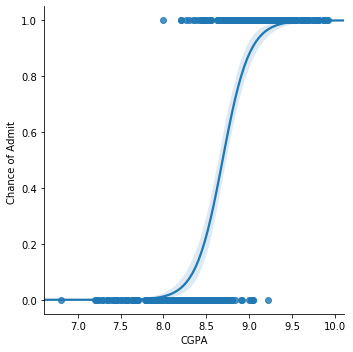

In [ ]:
sns.lmplot(x=dataset.columns[5], 
           y=dataset.columns[-1], 
           data=dataset,
           logistic=True)

5. Faites un barplot sur la colonne LOR / SOP / University Rating / Research

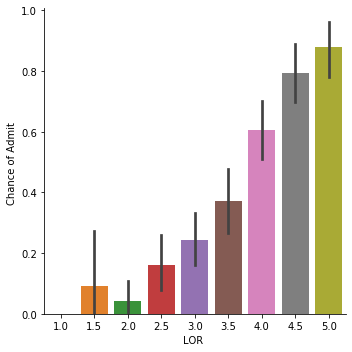

In [ ]:
sns.catplot(x=dataset.columns[4], 
           y=dataset.columns[-1], 
           data=dataset,
           kind="bar")

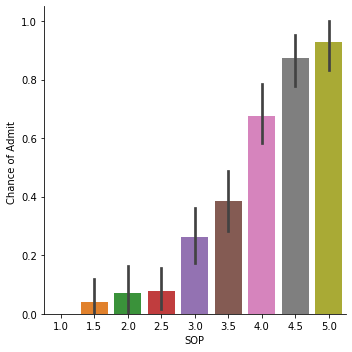

In [ ]:
sns.catplot(x=dataset.columns[3], 
           y=dataset.columns[-1], 
           data=dataset,
           kind="bar")

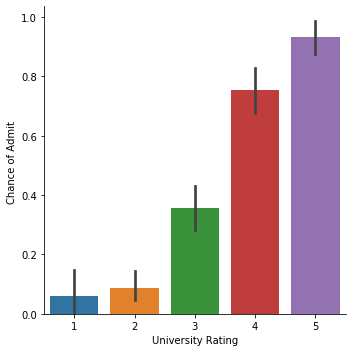

In [ ]:
sns.catplot(x=dataset.columns[2],
            y=dataset.columns[-1],
            data=dataset,
            kind="bar")

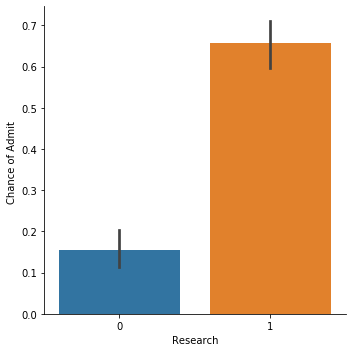

In [ ]:
sns.catplot(x=dataset.columns[-2],
            y=dataset.columns[-1],
            data=dataset,
            kind="bar")

6. Séparez votre dataset en variables explicatives : ```X``` & variable cible : ```y``` 

In [ ]:
X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]

7. Séparez votre dataset en données d'entrainement et de test 

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y)

8. Tentez de faire un premier arbre de décision et évaluez votre score dans une matrice de confusion

In [ ]:
from sklearn.tree import DecisionTreeClassifier
classifier_tree = DecisionTreeClassifier()
classifier_tree.fit(X_train, y_train)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
classifier_tree.score(X_test, y_test)

0.86

In [ ]:
classifier_tree.score(X_train, y_train)

1.0

In [ ]:
y_pred = classifier_tree.predict(X_test)

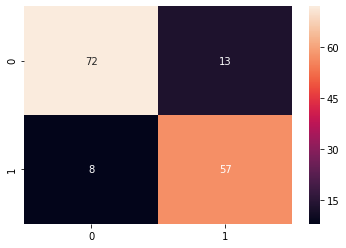

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")

In [ ]:
y_test.mean() #la classe la plus représentée est donc de 57% => element de comparaison !! Nbre de gens classés en O ou en 1 / Nbre total de gens à classer => ici 86% très bon versus 57%

0.43333333333333335

9. Visualisez votre arbre via graphviz 

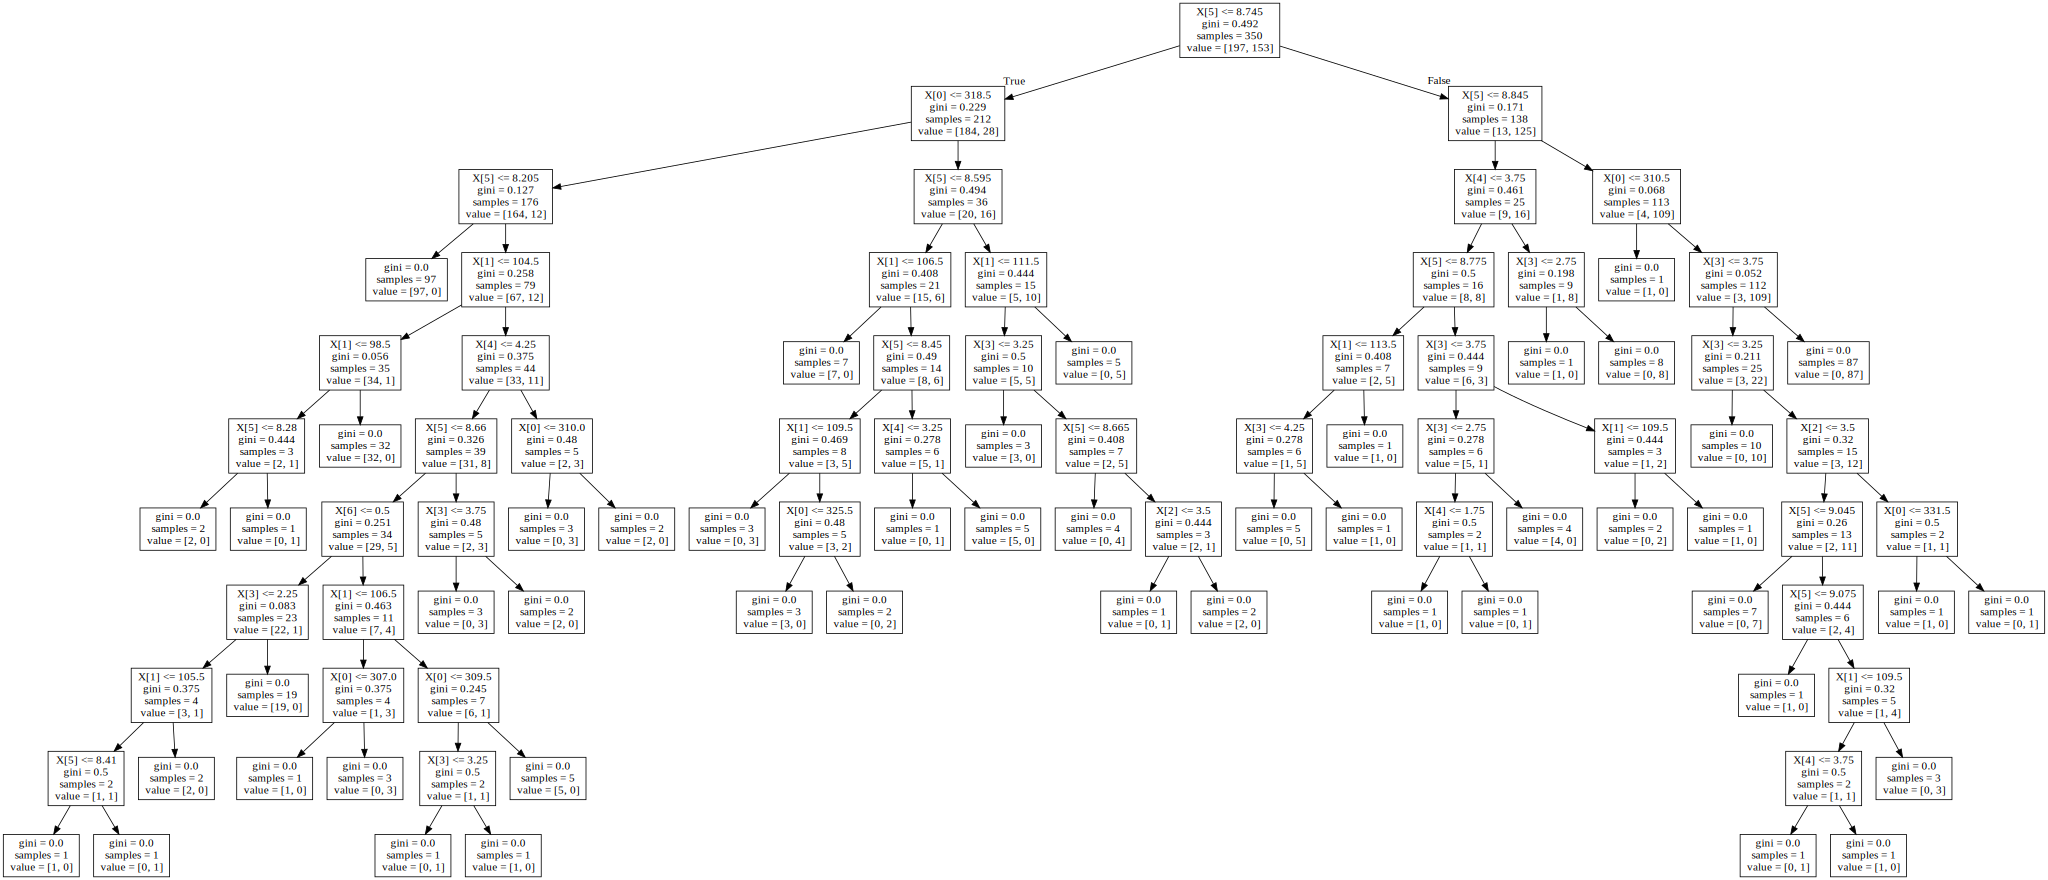

In [ ]:
import graphviz 
from sklearn.tree import export_graphviz
dot_data = export_graphviz(classifier_tree, out_file=None) 
graph = graphviz.Source(dot_data) 
graph

10. Classez les features les plus importantes qui déterminent les admissions 

In [ ]:
feature_importance = pd.DataFrame({"features": dataset.columns[:-1], "score": classifier_tree.feature_importances_}).sort_values(by="score", ascending=False)
feature_importance


,features,score
5,CGPA,0.690665
0,GRE Score,0.106565
1,TOEFL Score,0.074041
3,SOP,0.070290
4,LOR,0.039429
2,University Rating,0.010153
6,Research,0.008857


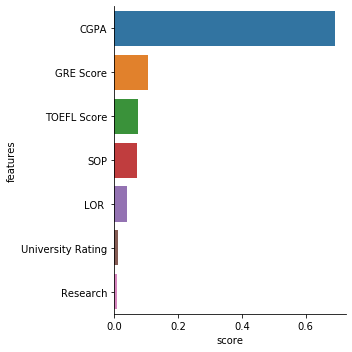

In [ ]:
sns.catplot(x="score",y="features", data=feature_importance, kind="bar" )

In [ ]:
classifier_tree.feature_importances_

array([0.10656516, 0.07404149, 0.01015313, 0.07028971, 0.0394285 ,
       0.69066513, 0.00885688])

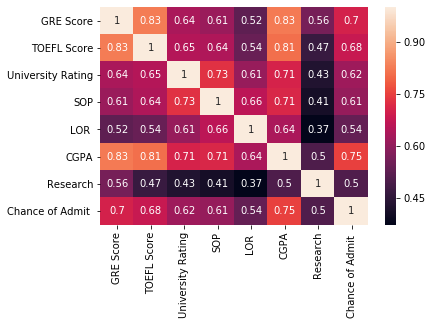

In [ ]:
sns.heatmap(dataset.corr(), annot=True)

11. Essayons d'améliorer notre score. Faites une Random Forest avec 50 arbres de decision

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=50)
rf_classifier.fit(X_train, y_train)
rf_classifier.score(X_train, y_train)

1.0

In [ ]:
rf_classifier.score(X_test, y_test)

0.9

12. Tentez de refaire le modèle avec uniquement 20 arbres 

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=20)
rf_classifier.fit(X_train, y_train)
rf_classifier.score(X_test, y_test)

0.9066666666666666

---> Il semblerait qu'il y ait un nombre optimum d'arbres.

13. Faites une Grid Search pour trouver le nombre optimum d'arbres 

In [ ]:
from sklearn.model_selection import GridSearchCV
rf_classifier_grid = RandomForestClassifier()
params = {"n_estimators": range(20, 50)}

classifier = GridSearchCV(cv=10, estimator = rf_classifier_grid, param_grid = params).fit(X_train, y_train)

In [ ]:
classifier.best_params_

{'n_estimators': 41}

In [ ]:
classifier.best_estimator_.score(X_test, y_test)

0.8866666666666667

14. Regardez les feature importance 

In [ ]:
pd.DataFrame({'importance':classifier.best_estimator_.feature_importances_, 'features':X_train.columns})

,importance,features
0,0.212911,GRE Score
1,0.190241,TOEFL Score
2,0.047373,University Rating
3,0.078497,SOP
4,0.062640,LOR
5,0.366872,CGPA
6,0.041466,Research


In [ ]:
RandomForestClassifier.feature_importances_?

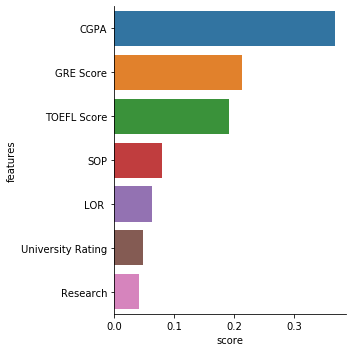

In [ ]:
feature_importance = pd.DataFrame({"features": dataset.columns[:-1], "score": classifier.best_estimator_.feature_importances_}).sort_values(by="score", ascending=False)
sns.catplot(x="score",y="features", data=feature_importance, kind="bar" )

In [ ]:
RandomForestClassifier?

In [ ]:
param = {"n_estimators": np.arange(10,50),
        "max_depth": np.arange(1,10),
        "min_samples_split":np.arange(2,10)}

In [ ]:
rf = RandomForestClassifier()
grid = GridSearchCV(rf, param_grid=param)
grid.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=No...
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8

In [ ]:
grid.best_params_

In [ ]:
grid.best_estimator_.score(X_test, y_test)

In [ ]:
misclass = X_test[(y_test==1) & (grid.best_estimator_.predict(X_test)==0)]
misclass2 = X_test[(y_test==0) & (grid.best_estimator_.predict(X_test)==1)]


In [ ]:
misclass2.describe()

In [ ]:
misclass.describe()

In [ ]:
X_test[y_test==1].describe()